In [342]:
import gym
import numpy as np
import sys
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.optim as optim
import torch.nn.functional as functional

In [343]:
class DualSourcing(gym.Env):

    def __init__(self, config):
        
        self.Lr = config['Lr']
        self.Le = config['Le']
        self.cr = config['cr']
        self.ce = config['ce']
        self.Lambda = config['lambda']
        self.h = config['h']
        self.b = config['b']
        self.starting_state = config['starting_state']
        self.max_order = config['max_order']
        self.max_inventory = config['max_inventory']
        
        self.state = np.asarray(self.starting_state)
        self.action_space = gym.spaces.MultiDiscrete([self.max_order+1]*2)
        self.observation_space = gym.spaces.MultiDiscrete([self.max_order+1]*(self.Lr+self.Le)+[self.max_inventory])
        
        self.nA = (self.max_order+1) ** 2
        
        metadata = {'render.modes': ['human']}
    
    def seed(self, seed=None):
        np.random.seed(seed)
        self.action_space.np_random.seed(seed)
        return seed
    
    def step(self, action):
        reward = self.r(self.state)
        
        demand = np.random.poisson(self.Lambda)
        newState = self.g(self.state, action)
        newState[-1] = newState[-1] - demand
        newState[-1] = max(-self.max_inventory, min(newState[-1], self.max_inventory))
        self.state = newState.copy()
        
        return self.state, reward, demand, {}
    
    # Auxilary function computing the reward
    def r(self, state):
        return -(self.cr*state[self.Lr-1] + self.ce*state[self.Lr+self.Le-1] + 
                 self.h*max(state[-1],0) + self.b*max(-state[-1],0))
    
    # Auxilary function
    def g(self, state, action):
        return np.hstack([state[1:self.Lr], action[0], state[self.Lr+1:self.Lr+self.Le], action[1],
                         state[self.Lr+self.Le]+state[0]+state[self.Lr]]).astype(int)
    
    def render(self, mode='human'):
        outfile = sys.stdout if mode == 'human' else super(DualSourcing, self).render(mode=mode)
        outfile.write(np.array2string(self.state)+'\n')

    def reset(self):
        self.state = np.asarray(self.starting_state)
        return self.state

In [344]:
class Model(nn.Module):
    def __init__(self, state_dim, action_space, hidden_size1):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size1)
        self.relu = nn.ReLU()
        
        self.action_head = nn.Linear(hidden_size1, action_space)
        self.action_output = nn.Softmax(dim = 0)
        
        self.value_output = nn.Linear(hidden_size1, 1)
        
        self.data = []

    def forward(self, s):
        out = self.fc1(s)
        out = self.relu(out)
        
        action_probs = self.action_head(out)
        action_probs = self.action_output(action_probs)
        
        value = self.value_output(out)
        
        return action_probs, value

# class Model(nn.Module):
#     def __init__(self, state_dim, action_space, hidden_size1, hidden_size2):
#         super(Policy, self).__init__()
#         self.fc1 = nn.Linear(state_dim, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.relu = nn.ReLU()
        
#         self.action_head = nn.Linear(hidden_size2, action_space)
#         self.action_output = nn.Softmax(dim = 0)
        
#         self.value_output = nn.Linear(hidden_size2, 1)
        
#         self.data = []
#         self.rewards = []

#     def forward(self, s):
#         out = self.fc1(s)
#         out = self.relu(out)
#         out = self.fc2(out)
#         out = self.relu(out)
        
#         action_probs = self.action_head(out)
#         action_probs = self.action_output(action_probs)
        
#         value = self.value_output(out)
        
#         return action_probs, value

In [345]:
def convergence_test(env, numiters, policy, *args):

    cum_reward = np.zeros(numiters)
    av_reward = np.zeros(numiters)
    
    env.reset() # reset environment
    for t in range(numiters-1):
        action = policy(*args)
        state, reward, demand, info = env.step(action)
        cum_reward[t+1] = cum_reward[t] + reward
        av_reward[t+1] = cum_reward[t+1] / (t+1)
    print(av_reward[-1])
        
    plt.plot(range(numiters), av_reward)
    plt.xlabel('time step')
    plt.ylabel('average reward')

def evaluate(env, n_episodes, numiters, policy, *args):
    
    av_reward = np.zeros(n_episodes)
    
    for i in range(n_episodes):
        av_r = 0
        env.reset() # reset environment
        for t in range(numiters):
            action = policy(*args)
            state, reward, demand, info = env.step(action)
            if t > 100 and np.abs( av_r / (t+1) - (av_r + reward) / (t+2))  < 1e-4: # convergence is spotted
                break
            av_r = av_r + reward
        av_reward[i] = av_r / (t+1)
        
    return np.mean(av_reward), np.std(av_reward) # return average reward and std

In [346]:
def nn_policy(env, model, m):
    state = torch.from_numpy(env.state).float()
    action_probs, value = model(state)
    
    dist = Categorical(action_probs)
    action = dist.sample()
    model.data.append([dist.log_prob(action), value])
    
    action = np.asarray([action.item() // m, action.item() % m])
    return action

def TBS(env, r, S):
    ip = np.sum(env.state[1:(env.Le+1)]) + np.sum(env.state[env.Lr:])
    return r, max(0, S-ip)

In [347]:
def initialize(env, model, r, S, stepsize=0.01, maxit=10000, seed=0):
    np.random.seed(seed)
    
    state_dim = env.observation_space.shape[0]
    m = env.max_order + 1
    n = env.Lambda + 1
    l = 2 * env.max_order + 1
    
    for i in range(maxit):
        s = np.random.rand(state_dim)
        s = np.floor(s * np.asarray([n]*(state_dim-1) + [l]))
        s[-1] -= env.max_order
        env.state = s

        qr, qe = TBS(env, r, S)
        action = m * qr + qe
        action = int(action)
        probs, _ = model(torch.from_numpy(s).float())
        
        model.zero_grad()
        loss = (probs ** 2).sum() - 2 * probs[action]
        loss.backward()

        for name, layer in model.named_modules():
            if type(layer) == nn.Linear and not (name == 'value_output'):
                layer.weight.data -= stepsize * layer.weight.grad
                layer.bias.data -= stepsize * layer.bias.grad

-1139.7871787178717


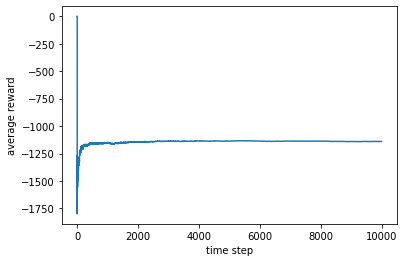

In [348]:
CONFIG = {'Lr': 5, 'Le': 1, 'cr': 100, 'ce': 105, 'lambda': 10,
          'h': 1, 'b': 19, 'starting_state': [0]*7, 'max_order': 20, 'max_inventory': 1000}

# env = gym.make('DualSourcing-v0', config=CONFIG)
env = DualSourcing(CONFIG)
env.seed(0)

state_dim = env.observation_space.shape[0]
action_space = env.nA

torch.manual_seed(0)
learning_rate = 0.01

model = Model(state_dim, action_space, 32)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

r = 5
S = 3
initialize(env, model, r, S)

m = env.max_order + 1
convergence_test(env, 10000, nn_policy, env, model, m)

In [352]:
def A2C(env, model, maxit, rollout, param = {}):
    if 'gamma' in param:
        gamma = param['gamma']
    else:
        gamma = 0.99
    
    if 'terminal_state' in param:
        terminal_state = param['terminal_state']
    else:
        terminal_state = None
    
    if 'loss_function' in param:
        loss_function = param['loss_function']
    else:
        loss_function = functional.smooth_l1_loss
    
    if 'value_weight' in param:
        value_weight = param['value_weight']
    else:
        value_weight = 1.0
    
    if 'env_seed' in param:
        env.seed(param['env_seed'])
    if 'torch_seed' in param:
        torch.manual_seed(param['torch_seed'])

    m = env.max_order + 1

    for i in range(maxit):
        state = env.reset()
        model.data = []
        rewards = []
        for t in range(rollout):
            action = nn_policy(env, model, m)
            state, reward, _, _ = env.step(action)
            rewards.append(torch.tensor(reward).float())
            
            if np.array_equal(state, terminal_state):
                break

        data = model.data
        discounted_reward = 0
        policy_loss = []
        value_loss = []
        T = len(rewards)
        for i in range(1, T+1):
            log_prob, value = data[-i]
            discounted_reward = rewards[-i] + gamma * discounted_reward
            advantage = discounted_reward - value.item()
            policy_loss.append(-advantage * log_prob)
            value_loss.append(loss_function(value, torch.tensor([discounted_reward])))

        optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum() + value_weight * torch.stack(value_loss).sum()
        loss.backward()
        optimizer.step()

In [353]:
maxit = 100
rollout = 1001
param = {'env_seed': 0, 'torch_seed': 0}

A2C(env, model, maxit, rollout, param)

-1070.030203020302


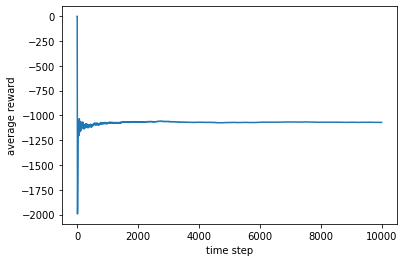

In [354]:
convergence_test(env, 10000, nn_policy, env, model, m)